# Checkpoint 7: Systematic Errors

`datafile-expresonance.txt` contains 10,000 measurements from a mass distribution, where m = mass.

It is described by:
- A fraction F=0.98 of events from a background exponential ~ exp(-m/A) where A = 5 
- A fraction (1-F) =0.02 of a signal Gaussian
- Gaussian mean M = 2.5 and width of 0.2
- There are only events in the range 0-10

In [22]:
# preamble
import numpy as np
import seaborn as sns
from scipy.stats import norm, crystalball, skewnorm
import scipy.integrate as integrate
from matplotlib import pyplot as plt

from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

<AxesSubplot:ylabel='Count'>

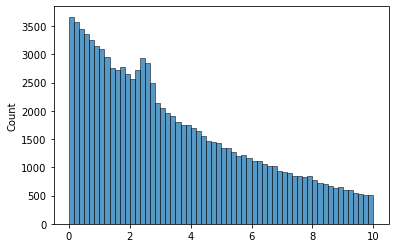

In [23]:
# load in data
mass = np.loadtxt('datafile-expresonance.txt')

#plot the data
sns.histplot(mass)

## Checkpoint 7 - Part 1
1. Fit to these data with the above model to determine the best fit parameters for F, A and M 
2. Determine the statistical errors on each fit parameter
    * If using optimise you will have to write a bit of code to find the NLL+0.5 points
    * If using Minuit then errors come free in the fit - but remember to set errordef=0.5
3. Present the best fit values and errors on all parameters in clear way, i.e. with descriptive text 
and numerical results presented as: M = Value ± Estat
4. Make sure the number of digits quoted is sensible – quote errors to 2 significant digits

In [24]:
def combined_pdf(x, f, a, m, x_min, x_max):
    scaling = np.exp( - x_min / a) - np.exp( - x_max / a)
    return (1 - f) * norm.pdf(x, m, 0.2) + f * 1 / a * np.exp( - x / a) / scaling

In [25]:
# check if the pdf is normalised, should be very close to 1
print("integral of the pdf over the whole range:",integrate.quad(lambda x: combined_pdf(x, 0.98, 5, 2.5, 0, 10), 0, 10)[0])

# use Minuit to perform a maximum likelihood estimation
cost = UnbinnedNLL(mass, combined_pdf)
# create the object with initual guesses for the parameters
m = Minuit(cost, f=0.98, a=5, m=2.5, x_min=0, x_max=10)
m.errordef = 0.5
m.limits['f'] = (0, 1)
m.fixed['x_min'] = True
m.fixed['x_max'] = True
m.migrad()
m.hesse()
# display the estimations and the errors
for p, v, e in zip(m.parameters, m.values, m.errors):
    # round to 2 sig fig
    v = np.format_float_positional(v, precision=2, unique=False, fractional=False, trim='k')
    e = np.format_float_positional(e, precision=2, unique=False, fractional=False, trim='k')
    print(f"{p} = {v} +/- {e}")

# get the value of the mass, for part 2
m_index = m.parameters.index('m')
mass = m.values[m_index]
mass_error = m.errors[m_index]

integral of the pdf over the whole range: 1.0000000000000002
f = 0.98 +/- 0.00082
a = 5.0 +/- 0.022
m = 2.5 +/- 0.010
x_min = 0.0 +/- 0.10
x_max = 10. +/- 0.10


## Checkpoint 7 - Part 2
1. Determine a systematic error on the mean of the Gaussian (M) by the “shift” method
2. Fit to the same data using the same Gaussian signal model but now using **a 2nd order 
polynomial background model**
3. Present the results clearly as Value ± Estat ± Esyst
4. Present the results as Value ± Etot
5. Comment on the importance of the systematic error compared to the statistical error 
for the measurement of M

In [26]:
##########
# Part 1 #
##########

# Using the shift method on the signal

# defining the pdf using the crystal ball method
def combined_pdf_cb(x, f, a, m, x_min, x_max):
    scaling = np.exp( - x_min / a) - np.exp( - x_max / a)
    return (1 - f) * crystalball.pdf(x, 0.2, m) + f * 1 / a * np.exp( - x / a) / scaling

# defining the pdf using the skew norm method
def combined_pdf_sn(x, f, a, m, x_min, x_max):
    scaling = np.exp( - x_min / a) - np.exp( - x_max / a)
    return (1 - f) * skewnorm.pdf(x, loc=m, scale=0.2, a=3) + f * 1 / a * np.exp( - x / a) / scaling

# check if the pdf is normalised, should be very close to 1
print("integral of the pdf for crystal ball:",integrate.quad(lambda x: combined_pdf_cb(x, 0.98, 5, 2.5, 0, 10), 0, 10)[0])
print("integral of the pdf for skew norm:",integrate.quad(lambda x: combined_pdf_sn(x, 0.98, 5, 2.5, 0, 10), 0, 10)[0])

# perform the same analysis as step 1 for the different methods
cost_cb = UnbinnedNLL(mass, combined_pdf_cb)
m_cb = Minuit(cost_cb, f=0.98, a=5, m=2.5, x_min=0, x_max=10)
m_cb.errordef = 0.5
m_cb.limits['f'] = (0, 1)
m_cb.fixed['x_min'] = True
m_cb.fixed['x_max'] = True
m_cb.migrad()
m_cb.hesse()

# get the value of the mass
m_index = m_cb.parameters.index('m')
mass_cb = m_cb.values[m_index]


cost_sn = UnbinnedNLL(mass, combined_pdf_sn)
m_sn = Minuit(cost_sn, f=0.98, a=5, m=2.5, x_min=0, x_max=10)
m_sn.errordef = 0.5
m_sn.limits['f'] = (0, 1)
m_sn.fixed['x_min'] = True
m_sn.fixed['x_max'] = True
m_sn.migrad()
m_sn.hesse()

# get the value of the mass
m_index = m_sn.parameters.index('m')
mass_sn = m_sn.values[m_index]

sys_error = mass / mass_cb / mass_sn

integral of the pdf for crystal ball: 0.9826055584515648
integral of the pdf for skew norm: 1.0


In [27]:
##########
# Part 2 #
##########

# calculate the error on the background using a polyfit

# combined pdf using a polynomial fit for the background
def combined_pdf_poly(x, f, b, c, m, x_min, x_max):
    scaling = - (x_min + 0.5 * b * x_min ** 2 + (1 / 3) * c * x_min ** 3) + (x_max + 0.5 * b * x_max ** 2 + (1 / 3) * c * x_max ** 3)
    # scaling = (1 + b * x_min + c * x_min ** 2) - (1 + b * x_max + c * x_max ** 2)
    return (1 - f) * norm.pdf(x, m, 0.2) + f * (1 + b * x + c * x ** 2) / scaling


# check if the pdf is normalised, should be very close to 1
print("integral of the pdf for crystal ball:",integrate.quad(lambda x: combined_pdf_poly(x, 0.98, -0.016, 0.007, 2.5, 0, 10), 0, 10)[0])

# perform the same analysis as step 1 for the different methods
cost_poly = UnbinnedNLL(mass, combined_pdf_poly)
m_poly = Minuit(cost_poly, f=0.98, b=-0.016, c=0.007, m=2.5, x_min=0, x_max=10)
m_poly.errordef = 0.5
m_poly.limits['f'] = (0, 1)
m_poly.fixed['x_min'] = True
m_poly.fixed['x_max'] = True
m_poly.migrad()
m_poly.hesse()

# get the value of the mass
m_index = m_poly.parameters.index('m')
mass_poly = m_poly.values[m_index]
bkg_error = mass / mass_poly



integral of the pdf for crystal ball: 1.0
E VariableMetricBuilder Initial matrix not pos.def.


C:\Users\Gamer2021\anaconda3\envs\daml\lib\site-packages\iminuit\cost.py:18: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(x + 1e-323))


In [28]:
##########
# Part 3 #
##########
# present the mass as mass = m_gauss +/- error_gauss +/- sys_error
mass_str = np.format_float_positional(mass, precision=2, unique=False, fractional=False, trim='k')
mass_error_str = np.format_float_positional(mass_error, precision=2, unique=False, fractional=False, trim='k')
sys_error_str = np.format_float_positional(sys_error, precision=2, unique=False, fractional=False, trim='k')
print("mass in form mass = m_gauss +/- error_gauss +/- sys_error:")
print(f"m = {mass_str} +/- {mass_error_str} +/- {sys_error_str}")

# present the mass as mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error
bkg_error_str = np.format_float_positional(bkg_error, precision=2, unique=False, fractional=False, trim='k')
print("mass in the form mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error")
print(f"m = {mass_str} +/- {mass_error_str} +/- {sys_error_str} +/- {bkg_error_str}")

mass in form mass = m_gauss +/- error_gauss +/- sys_error:
m = 2.5 +/- 0.010 +/- 0.32
mass in the form mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error
m = 2.5 +/- 0.010 +/- 0.32 +/- 1.0


In [29]:
##########
# Part 4 #
##########

# present the error as mass = m_gauss +/- e_tot

e_tot = np.sqrt(mass_error ** 2 + sys_error ** 2 + bkg_error ** 2)

e_tot_str = np.format_float_positional(e_tot, precision=2, unique=False, fractional=False, trim='k')
print("mass in the form mass = m_gauss +/- e_tot")
print(f"m = {mass_str} +/- {e_tot_str}")

mass in the form mass = m_gauss +/- e_tot
m = 2.5 +/- 1.0


### Part 5

While the statistical error highlights the deviation of the data from the model, the systematic error here is highlighting any biases in the data. The systematic error indicates a bias of 0.32 in the signal, and the background error indicates a bias of 1 to the background. 

## Checkpoint 7 - Part 3
1. Determine a systematic error on the mean of the Gaussian by the "shift" method
2. Fit to the same data using the same Gaussian signal model but now using **straight line background model** (bad model - this is harder)
3. Present the result clearly as M ± Estat ± Esyst
4. Present the results as M ± Etot
5. Comment on the importance of the systematic error compared to the statistical error for the measurement of M

In [33]:
##########
# Part 1 #
##########
# use the same result of the previous question

##########
# Part 2 #
##########

# create a pdf for a straight line background model
def combined_pdf_linear(x, f, a, b, m, x_min, x_max):
    scaling = (0.5 * a * x_max ** 2 + b * x_max) - (0.5 * a * x_min ** 2 + b * x_min)
    return (1 - f) * norm.pdf(x, m, 0.2) + f * (a * x + b) / scaling

# check if the pdf integrates to unity
print("integral of the pdf for linear:",integrate.quad(lambda x: combined_pdf_linear(x, 0.98, 1, -0.09, 2.5, 0, 10), 0, 10)[0])

# perform the same analysis as step 1 for the different methods
cost_linear = UnbinnedNLL(mass, combined_pdf_linear)
m_linear = Minuit(cost_linear, f=0.98, a=1, b=-0.09, m=2.5, x_min=0, x_max=10)
m_linear.errordef = 0.5
m_linear.limits['f'] = (0, 1)
m_linear.fixed['x_min'] = True
m_linear.fixed['x_max'] = True
m_linear.migrad()
m_linear.hesse()

# get the value of the mass
m_index = m_linear.parameters.index('m')
mass_linear = m_linear.values[m_index]
bkg_error = mass / mass_linear


##########
# Part 3 #
##########

# present the mass as mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error
bkg_error_str = np.format_float_positional(bkg_error, precision=2, unique=False, fractional=False, trim='k')
print("mass in the form mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error")
print(f"m = {mass_str} +/- {mass_error_str} +/- {sys_error_str} +/- {bkg_error_str}")

##########
# Part 4 #
##########

# present the error as mass = m_gauss +/- e_tot

e_tot = np.sqrt(mass_error ** 2 + sys_error ** 2 + bkg_error ** 2)

e_tot_str = np.format_float_positional(e_tot, precision=2, unique=False, fractional=False, trim='k')
print("mass in the form mass = m_gauss +/- e_tot")
print(f"m = {mass_str} +/- {e_tot_str}")

integral of the pdf for linear: 0.9999999999999999
mass in the form mass = m_gauss +/- error_gauss +/- sys_error +/- bkg_error
m = 2.5 +/- 0.010 +/- 0.32 +/- 1.0
mass in the form mass = m_gauss +/- e_tot
m = 2.5 +/- 1.1
